# Programming Exercise 6: Neural Networks

Neural networks (NN) are essentially the closest we've come to universal function approximators. All the hype you've been hearing about Deep Learning and "AI" are due to advances in NNs. These beasts deserve a separate course, but here you'll get to learn how a basic NN works

If you recall logistic regression, we model a classification problem as a non-linear function of the input vector.
When the problem in question is quite complicated, and the number of possible input features are large, simple classification, regression or classic ML techniques have limited ability. Composing functions of functions, say $f( g( h(X,W_{0}),W_{1}),W_{2}) $ would be better equipped to 'learn' more complicated functions. 

NNs are effectively compositions of functions consisting of layers of 'nodes'. The permuted connections between these nodes allow complex 'functions' to be 'learnt'. Depicted below is a 3-layer NN, consisting of an input layer, a 'hidden' layer and an output layer.

Why provide an elaborate explanation when this beautiful visualization exists:
https://www.youtube.com/watch?v=aircAruvnKk ?

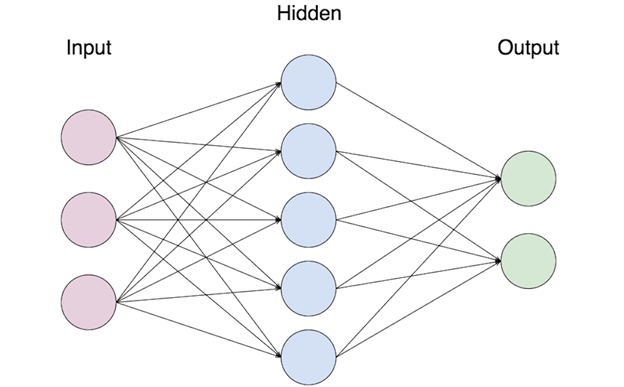

In [1]:
from IPython.display import Image
Image("nn.png")

### To start off, let's first visualise logistic regression in terms of a NN

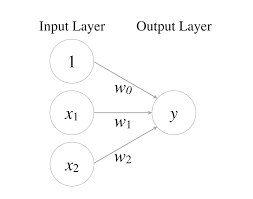

In [2]:
from IPython.display import Image
Image("nnlogic.png")

Here we have a 2-layer NN, which is effectively a logistic regression model. The input layer is X and output layer is a single node y. The connections from the input layer to the output layer represent the weights that are to be 'learnt', and represented as a matrix W such that sigmoid(W*X) = y

So a 3-Layer NN with a h-neuron hidden layer would essentially be h ~logistic regressions of the input times y ~logistic regressions of the hidden layer. So there would be x*h + h*w weights to be learnt.

## Forward Pass

The computation of the output layer by composing functions through each hidden layer is called forwards propagation. These functions are called 'activations' and are non-linear in nature. Let's say we have an input feature vector X, a single hidden layer witha sigmoid activation and an output layer with a sigmoid activation.

A forward-pass is then given by:

$ Y' = \sigma( W_{2}.( \sigma( W_{1}.X)))$

Where $W_{1}$ and $W_{2}$ are the weights/parameters to be learnt, $X$ is the input vector and $Y'$ is the output vector of the NN 

## Back-Propagation

Remember how we optimised the model in logistic regression? We used the partial differentials of the Cost function w.r.t the weight we were trying to optimize. Same concept, but because we have a composition of functions, we use the chain rule. So let's say cost function $J(x,W_{1},W_{2}, Y) = f( g(x,W_{1}),W_{2},Y) $. 
Then $  \frac{\delta J}{\delta W_{1}} = \frac{\delta f}{\delta g} * \frac{\delta g}{\delta W_{1}} $

The optimising step would then be $ W_{1} \rightarrow W_{1} - \alpha*\frac{\delta J}{\delta W_{1}}$

## In order to get a better grasp of how NNs work, let's build one from scratch using numpy and python

This tutorial uses python classes in order to build a kind of NN-library. This is to help us breakdown the different components that go into a NN and then be able to build different architectures of NN more easily. 

This also allows us to peek into the inner workings of the NN since we can print the weights between any two layers to understand what is happening there. 

You are required to complete the code where it says # INSERT CODE HERE #

It is advised to run 'unit' tests on each block you finish, where possible, by perhaps using a random array.

### A quick primer on python objects:

In [3]:
class Object:                    #This is a class, it can have 'members' that are functions or data
    def __init__(self,x):          # the __init__ function initialises the class Object whenever a object is declared
        self.A = x               # here, a data member A (accessed as self.A) is assigned x whenever an object is created
    def mem_function(self,X):    # this is a member function, it can access the class's data and use external parameters
        self.B = self.A+X        # here another data member is created and assigned a value
        
obj = Object(2)                  # here an Object object is created as obj
obj.mem_function(3)              # here the member function is called using <class_name>.<functoin_name>
obj.B                            # this is how the object's data can be accessed

5

In [4]:
import numpy as np
import struct
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

### Data Preprocessing

The below functions are trivial and can be skipped, unless, you want to come up with a cleaner way to do them ;)

In [5]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
    
def flatten_imgs(X):
    n_img = np.shape(X)[0]
    h = np.shape(X)[1]
    w = np.shape(X)[2]
    size_arr = h*w
    return np.reshape(X,(n_img,size_arr))

### One hot encoding 

One hot encoding is basically representing a class as a boolean vector: e.g if we have 3 classes (let's say classes 1,2,3 ) and we want to represent class '1'. We would do this as [1 0 0]$^{T}$. Class '2' would be [0 1 0]$^{T}$ and so on.. 

One hot encoding allows us to output a probability distribution vector [p1 p2 p3]$^{T}$ such that these probabilities represent the likelihood of the particular class. So a vector [0.9 0.02 0.08]$^{T}$ would mean that the output represents class 1 with a 0.9 probability

In [6]:
def one_hot(Y,n_class):
    length = np.shape(Y)[1]
    O = np.zeros((n_class,length))
    for i in range(length):
        j = int(Y[0,i])
        O[j,i] = 1
    return O



It is useful to have the inverse encoding from on-hot representation. Thus:

In [7]:
def inv_one_hot(O):
    n_class = np.shape(O)[0]
    length = np.shape(O)[1]
    Y = np.zeros((1,length))
    for i in range(length):
        j = np.argmax(O[:,i])
        Y[0,i] = j
    return Y

Neural networks can quickly get messy if the input data is not normalized. You could try implementing the NN without normalizing the data and find out how it affects the performance.

In [8]:
def normalize(X):
    mean = np.mean(X)
    std =  np.std(X)
    N_X = (X-mean)/(std)
    return N_X

In order to effectively measure the performance of our model we can define a 'metric'. Here we use a straight-forward 'right or not' method

In [9]:
def model_accuracy(H,Y):
    # H and Y have to be one-hot matrices
    n = np.shape(H)[1]
    err = 0
    O = inv_one_hot(H)
    L = inv_one_hot(Y)
    for i in range(n):
        if O[0,i]!=L[0,i]:
            err += 1
    accuracy = (1 - err/n)
    
    return accuracy

## Activation Functions

Each node except those in the input layer represents an activation function, which applies a 'non-linearity' to its input parameter.

ML Researchers have empirically found several different activation functions to work with their respective pros and cons. Listed below are the most popular.
Softmax is a unique activation function in that it is used in multiclass classification i.e for categorical data.

For some more comprehension: https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html

|Activation|Equation|
|----|---------|
|<img width=50/>|<img width=100/>|
|Sigmoid| $ \sigma(x) = \frac{1}{1+e^{-x}} $ |
| Tanh | $tanh(x)$ |
| ReLu | $ max(0,x)$    |
| Softmax| $ \frac{e^{x_{i}}}{\sum e^{x_{i}}} $ |

In [10]:
class sigmoid:
    def activate(Z):
        A = 1/(1+np.exp(-Z))
        return A
    
    def diff(self,Z):
        dsig = np.multiply(self.activate(Z),(1-self.activate(Z)))
        return dsig
    
class relu:
    def activate(Z):
        A = Z*(Z>0)
        return A
    
    def diff(self,Z):
        d_rel = 1*(Z>0)
        return d_rel
    
# wrong implementation of leaky
class leaky_relu:
    def activate(Z):
        A = Z if (Z.all()>0.001*Z.all()) else 0.001*Z
        return A
    
    def diff(self,Z):
        d_lrel = 1 if (Z.all()>0.001*Z.all()) else 0.001
        return d_lrel
    
class tanh:
    def activate(Z):
        A = np.tanh(Z)
        return A

    def diff(self,Z):
        d_tanh = 1 - (np.multiply(self.activate(Z),self.activate(Z)))
        return d_tanh
    
class softmax:
    """Compute softmax values for each sets of scores in x."""
    def activate(Z):
        e_Z = np.exp(Z- np.max(Z,axis=0))
        return e_Z / e_Z.sum(axis=0)
    
    def diff(Z):
        return Z
    


## Loss Functions

Loss functions or 'Cost functions' are what are to be minimised. They act as a proxy of the performance of the NN. 

For more comprehension: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html

In [11]:
class CE_loss:
    def get_loss(H,Y):
        L = -np.mean(np.multiply(Y,np.log(H)))
        return L
    
    def diff(H,Y):
        dZ = H - Y 
        return dZ

### Weight Initialization

Initialization of the weights of a neural network can affect its performance. 
Empirically, it was found that each activation function has its own 'optimal' initialization

Initializations taken from : https://medium.com/usf-msds/deep-learning-best-practices-1-weight-initialization-14e5c0295b94

In [12]:
def init_theta(n1,n2,activation):
    if activation in [sigmoid,softmax]:
        M = np.random.randn(n2,n1)*np.sqrt(2./n1)
    elif activation in [relu,leaky_relu] :
        M = np.random.randn(n2,n1)*np.sqrt(1./n1)
    elif activation == tanh:
        M = np.random.randn(n2,n1)*np.sqrt(1./(n1+n2))
    return M

## A Layer of neurons

Recall that each layer has a weight matrix and a bias vector associated with it.
During forward pass, the weights and bias are used in computing basis function Z of input vector A(l-1) and subsequently activations A(l) for the layer

In [13]:
class layer:
    def __init__(self, n_prev, n_next, activation):
        self.W = init_theta(n_prev, n_next, activation)
        self.B = init_theta(1, n_next, activation)
        self.activation = activation
        self.V_dW = np.zeros(self.W.shape)
        self.V_dB = np.zeros(self.B.shape)
        
    def forward(self, A0):
        self.Z = np.dot(self.W, A0) + self.B
        self.A = self.activation.activate(self.Z)
        return self.A
    
    def grad(self, dZ, W, A0, m):
        dA = np.dot(W.T, dZ)
        dAdZ = self.activation.diff(self.activation, self.Z)
        self.dZ = np.multiply(dA, dAdZ)
        self.dW = (1./m)*np.dot(self.dZ, A0.T)
        self.dB = (1./m)*(np.sum(self.dZ, axis=1, keepdims=True))
    
    def out_grad(self, dZ, A0, m):
        self.dZ = dZ
        self.dW = (1./m)*np.dot(self.dZ, A0.T)
        self.dB = (1./m)*(np.sum(self.dZ, axis=1, keepdims=True))
        
    def step(self, lr, beta):
        self.V_dW = (beta * self.V_dW + (1. - beta) * self.dW)
        self.V_dB = (beta * self.V_dB + (1. - beta) * self.dB)
        self.W = self.W - lr*self.V_dW
        self.B = self.B - lr*self.V_dB

## Optimizer

NNs can be quite tricky to optimize because of the sheer number of parameters. Optimization can quickly get out of hand. A mini-batch gradient descent method is empirically shown to perform best and with decent stability. This is also called stochastic gradient descent interchangeably.

In [14]:
def SGD(batch_size,X,Y,model,lr,beta):
    m = np.shape(X)[1]
    for i in range(0,m,batch_size):
        X_batch = X[:,i:i+batch_size]
        Y_batch = Y[:,i:i+batch_size]
        model.f_pass(X_batch)
        model.back_prop(X_batch,Y_batch,batch_size)
        model.optim(lr,beta)
    return model.loss

## Training

The NN is finally trained for n_epochs and a plot of the training accuracy and test accuracy over n_epochs is displayed. This helps determine overfit/underfit and tuning of the hyperparameters.

Nothing fancy to be done here. We are just calling SGD on our model: mnist_net using the hyperparameters we defined previously. We are appyling inv_one_hot transformations in order to be able to calculate the metric we defined earlier

In [15]:
def train(model, X, Y, X_test, Y_test, metric, n_epochs=100, batch_size=4, lr=0.01, lr_decay=1, beta=0, reg_lambda=0):
    data_size = X.shape[1]
    for e in range(n_epochs):
        #shuffle dataset
        # shuffling helps remove possible serial-relations between data, and reduces 'memorisation'
        np.random.seed(138)
        shuffle_index = np.random.permutation(data_size)
        X, Y = X[:,shuffle_index], Y[:,shuffle_index]

        #SGD with momentum
        loss = SGD(batch_size,X,Y,model,lr,beta, reg_lambda)
        
        #decay helps decrease the size of steps over time, improving stability and convergence
        lr = lr*lr_decay
        
        #train accuracy
        H = model.f_pass(X)
        tr_acc = metric(H,Y)
        
        #test accuracy
        H = model.f_pass(X_test)
        acc = metric(H,Y_test)

        #plot train accuracy and test accuracy vs epochs
        plt.plot(e,tr_acc, 'bo')
        plt.plot(e,acc,'ro')
        clear_output()
        print(f"epoch:{e+1}/{n_epochs} | Loss:{loss:.4f} | \
            Train Accuracy: {tr_acc:.4f} | Test_Accuracy:{acc:.4f}")
        
    #plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.show()

# Part A: Logistic Regression as a 2-Layer NN

Let's repeat the logistic regression exercise on ex2data1.csv as done in week 2, this time based on a 2-layer NN.


### Loading data, and partitioning train and test set

If you want to find out what happens when the input is not normalized, comment out the normalize function calls

In [16]:
# Simple Train/test split seems to cause a high error - Shuffle df for better results
import pandas as pd
from atlas_ml import *
df = pd.read_csv('Datasets/Regression/ex2data1.csv')
A2 = df.values.T
X1 = A2[0:2,0:-10]
X2 = normalize(X1)
Y1 = A2[2:3,0:-10]
Y2 = one_hot(Y1,2)
X1_test = A2[0:2,-10:]
X2_test = normalize(X1_test)
Y1_test = A2[2:3,-10:]
Y2_test = one_hot(Y1_test,2)

In [17]:
def plotData(data, label_x, label_y, label_pos, label_neg, axes=None):
    if axes == None:
        axes = plt.gca()
    neg = data[:,2] == 0
    pos = data[:,2] == 1
    axes.scatter(data[pos][:,0], data[pos][:,1], marker='+', c='k', s=60, linewidth=2, label=label_pos)
    axes.scatter(data[neg][:,0], data[neg][:,1], c='y', s=60, label=label_neg)
    axes.set_xlabel(label_x)
    axes.set_ylabel(label_y)
    axes.legend(frameon= True, fancybox = True);

## Below we define the Logistic regression model as a 2 layer NN

In [18]:
class Logistic:
    def __init__(self, X_size, Y_size, lossfn):
        self.regressor = layer(X_size, Y_size, softmax)
        self.lossfn = lossfn
        
    def f_pass(self, X):
        self.H = self.regressor.forward(X)
        return self.H
    
    def back_prop(self, X, Y, batch_size, reg_lambda):
        m = batch_size
        self.loss = self.lossfn.get_loss(self.H,Y)
        dZ = self.lossfn.diff(self.H,Y)
        self.regressor.out_grad(dZ, X, m, reg_lambda)
    
    def optim(self, lr, beta=0):
        self.regressor.step(lr,beta)

In [19]:
n_in = np.shape(X2)[0]
n_out = np.shape(Y2)[0]
log_reg = Logistic(n_in,n_out,CE_loss)

In [20]:
n_epochs = 300
lr = 0.01
lr_decay = 1
batch_size = X2.shape[1] # Batch gradient descent
beta = 0

#regularization parameter labmda
reg_lamda = 1

epoch:100/100 | Loss:0.0821 |             Train Accuracy: 0.9000 | Test_Accuracy:0.6000


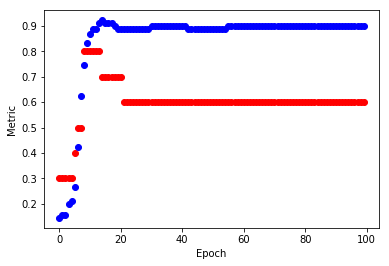

In [22]:
train(log_reg, X2, Y2, X2_test, Y2_test, model_accuracy, n_epochs=100, batch_size=4, lr=0.01)

In [23]:
H = log_reg.f_pass(X2)
H2 = inv_one_hot(H)
A3 = np.vstack([X1,H2])

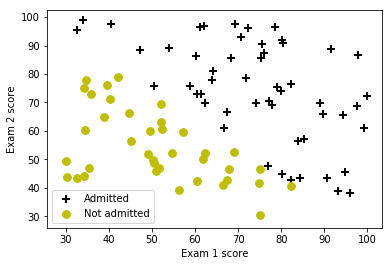

In [24]:
plotData(A3.T, 'Exam 1 score', 'Exam 2 score', 'Admitted', 'Not admitted')

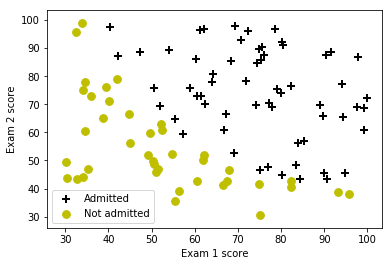

In [25]:
plotData(A2.T, 'Exam 1 score', 'Exam 2 score', 'Admitted', 'Not admitted')

# Part B: 1 Hidden Layer 

Now we add a hidden layer to this Logistic-Regression-like NN and try to get similar or better results.

In [26]:
class HL_net:
    def __init__(self, X_size, Y_size, lossfn):
        self.L1 = layer(X_size, 100, relu)
        self.L2 = layer(100, 20, relu)        
        self.L3 = layer(20, Y_size, softmax)
        self.lossfn = lossfn
        
    def f_pass(self, X):
        A1 = self.L1.forward(X)
        A2 = self.L2.forward(A1)
        A3 = self.L3.forward(A2)
        self.H = A3
        return self.H
    
    def back_prop(self,X,Y, batch_size,reg_lambda):
        m = batch_size
        self.loss = self.lossfn.get_loss(self.H,Y)
        dZ = self.lossfn.diff(self.H,Y)
        self.L3.out_grad(dZ, self.L2.A, m,reg_lambda)
        self.L2.grad(self.L3.dZ, self.L3.W, self.L1.A, m, reg_lambda)
        self.L1.grad(self.L2.dZ, self.L2.W, X, m, reg_lambda)
    
    def optim(self, lr, beta=0):
        self.L1.step(lr,beta)
        self.L2.step(lr,beta)
        self.L3.step(lr,beta)

In [27]:
n_in = np.shape(X2)[0]
n_out = np.shape(Y2)[0]
bin_clas = HL_net(n_in,n_out,CE_loss)

In [28]:
n_epochs = 200
lr = 0.01
lr_decay = 0.99
batch_size = 4 # mini-batch gradient descent here
beta = 0.9

#regularization parameter labmda
reg_lamda = 1

epoch:100/100 | Loss:0.0396 |             Train Accuracy: 0.9889 | Test_Accuracy:0.6000


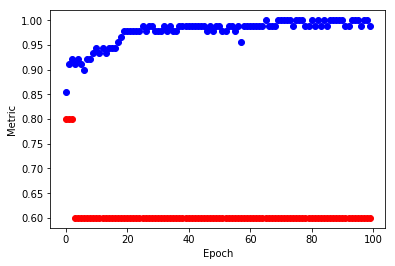

In [31]:
train(bin_clas, X2, Y2, X2_test, Y2_test, model_accuracy, n_epochs=100, batch_size=4, lr=0.01)

See how training accuracy is way higher than test accuracy?

This is mainly because of overfitting, and partially because we have such a small dataset over which we repeat training.

The act of stopping training at a relatively high training accuracy such that the test accuracy does not decrease further w.r.t the train accuracy is called early stopping and this controls overfitting.

# Part C: Let's Classify images!

We finally get to define the NN below. We are free to choose the number of hidden layers and the respective sizes, the activation functions for each of these, the loss function etc. This is where the object oriented setup helps.

In [35]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
    
X = read_idx('../Deep_Learning/MNIST_np/data/MNIST/train/train-images-idx3-ubyte')
X = flatten_imgs(X)
X = normalize(X)               # Try without this
X = np.transpose(X)

Y = read_idx('../Deep_Learning/MNIST_np/data/MNIST/train/train-labels-idx1-ubyte')
Y = np.expand_dims(Y, axis=1)
Y = np.transpose(Y)
Y = one_hot(Y,10)

X_test = read_idx('../Deep_Learning/MNIST_np/data/MNIST/test/t10k-images.idx3-ubyte')
X_test = flatten_imgs(X_test)
X_test = normalize(X_test)     # Try without this
X_test = np.transpose(X_test)

Y_test = read_idx('../Deep_Learning/MNIST_np/data/MNIST/test/t10k-labels.idx1-ubyte')
Y_test = np.expand_dims(Y_test, axis=1)
Y_test = np.transpose(Y_test)
Y_test = one_hot(Y_test,10)

### Let's visualise what one sample of our dataset looks like

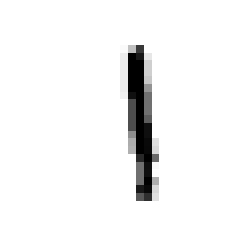

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [36]:
i = 8
plt.imshow(X[:,i].reshape(28,28), cmap = matplotlib.cm.binary)
plt.axis("off")
plt.show()
print(Y[:,i])

In [46]:
class MNIST_net:
    def __init__(self, X_size, Y_size, lossfn):
        self.L1 = layer(X_size, 500, relu)
        self.L2 = layer(500, 150, relu)        
        self.L3 = layer(150, Y_size, softmax)
        self.lossfn = lossfn
        
    def f_pass(self, X):
        A1 = self.L1.forward(X)
        A2 = self.L2.forward(A1)
        A3 = self.L3.forward(A2)
        self.H = A3
        return self.H
    
    def back_prop(self,X,Y, batch_size,reg_lambda):
        m = batch_size
        self.loss = self.lossfn.get_loss(self.H,Y)
        dZ = self.lossfn.diff(self.H,Y)
        self.L3.out_grad(dZ, self.L2.A, m,reg_lambda)
        self.L2.grad(self.L3.dZ, self.L3.W, self.L1.A, m, reg_lambda)
        self.L1.grad(self.L2.dZ, self.L2.W, X, m, reg_lambda)
    
    def optim(self, lr, beta=0):
        self.L1.step(lr,beta)
        self.L2.step(lr,beta)
        self.L3.step(lr,beta)

We create the model below

In [47]:
#Model creation
n_in = np.shape(X)[0]
n_out = np.shape(Y)[0]
mnist_net = MNIST_net(n_in,n_out,CE_loss)

## Hyperparameters

Parameters that define the training and the NN are called Hyperparameters ( so Meta!)
These include the learning rate, the batch size for the SGD, the decay in the learning rate etc

In [48]:
#Hyperparameters feel free to tweak these!

#lies in [1,X.shape[1]], preferably powers of 2
# 1 -> stochastic descent
# X.shape[1] -> batch descent
batch_size = 32

#learning rate
lr = 0.075

n_epochs = 10

#learning rate decay parameter, lies in [0,1]
lr_decay = 0.9

#momentum parameter, lies in [0,1]
beta = 0

# let this be
data_size = X.shape[1]

epoch:10/10 | Loss:0.0000 |             Train Accuracy: 1.0000 | Test_Accuracy:0.9843


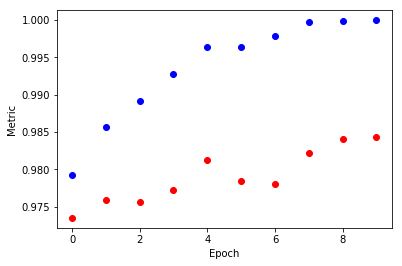

In [50]:
train(mnist_net, X, Y, X_test, Y_test, model_accuracy, n_epochs, batch_size, lr)

# Part D: The empirical process of practical deep learning

We have defined a 3-layer NN to classify handwritten digits.

Play around with the depth of the NN (add more layers), the width of the layers (add more nodes), the hyperparameters, the activation functions and observe the effects these bear on the performance of the NN

In [56]:
n_in = np.shape(X)[0]
n_out = np.shape(Y)[0]
mnist_net = MNIST_net(n_in,n_out,CE_loss)

In [57]:
n_epochs = 1
lr = 0.01
lr_decay = 0.99
beta = 0.9
batch_size = 4
#regularization parameter labmda
reg_lamda = 1

epoch:1/1 | Loss:0.0000 |             Train Accuracy: 1.0000 | Test_Accuracy:0.9846


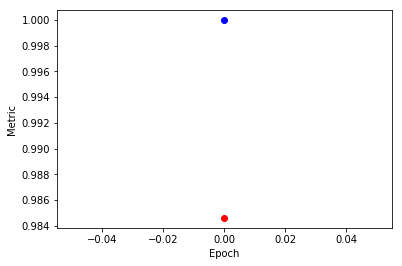

In [55]:
#call train() with appropriate model and parameters
train(mnist_net, X, Y, X_test, Y_test, model_accuracy, n_epochs, batch_size, lr)

Make your observations below: